In [1]:
from datetime import datetime, timedelta

import astropy.units as u
from heliopy.data import ace

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np
import sunpy.map

import helpers

In [2]:
from fig_params import figwidth, fontsize
import matplotlib
matplotlib.rcParams['figure.figsize'] = (figwidth, figwidth)
matplotlib.rcParams['font.size'] = fontsize

Load in-situ data
---

In [3]:
starttime = helpers.ace_dates[0]
endtime = helpers.ace_dates[1]

swics_data = ace.swi_h3b(starttime, endtime)
mag_data = ace.mfi_h2(starttime, endtime)
proton_data = ace.swe_h2(starttime, endtime)

Put mag and proton data on to a common time index
---

In [4]:
proton_data.data = proton_data.data.drop_duplicates()
mag_data.data = mag_data.data.drop_duplicates()
mag_data.data = mag_data.data.reindex(proton_data.index, method='nearest')

Filter out bad values in proton velocity
---

In [5]:
vp_r = proton_data.quantity('V_RTN_0')
vp_r[vp_r < 0] *= np.nan

Create list of different intervals
---
The CMEs are for shading, the AR and CH are for getting average values from each stream later.

In [6]:
cme_times = [[datetime(2013, 1, 16, 18), datetime(2013, 1, 18, 12)],
             [datetime(2013, 1, 18, 12), datetime(2013, 1, 19, 17)]]

ar_outflow_times = [[datetime(2013, 1, 24, 0, 0), datetime(2013, 1, 25, 0, 45)]]
ch_times = [[datetime(2013, 1, 13, 0), datetime(2013, 1, 16, 12)],
            [datetime(2013, 1, 25, 4), datetime(2013, 1, 29, 6)]]

Get traced field lines
---

In [7]:
flines, pfss_input, pfss_output = helpers.get_L1_flines()

Computing PFSS...
Tracing field lines...


Calculate Parker spiral deviation
---

In [8]:
# Calculate predicted spiral
Bphi_parker = helpers.parker_angle(vp_r)
# Calculate actual spiral
Bphi_actual = -np.arctan2(-mag_data.quantity('BGSEc_1'), -mag_data.quantity('BGSEc_0')).to(u.deg)
# Get difference between the two
dBphi = np.abs(Bphi_actual - Bphi_parker)
pol_l1 = dBphi < 90 * u.deg
pol_l1 = pol_l1.astype(int)
pol_l1[pol_l1 == 0] = -1

/Users/dstansby/miniconda3/envs/pub-env/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in less
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


Check Parker spiral deviations
---

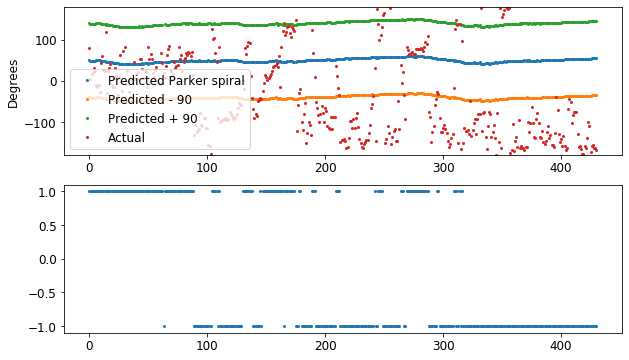

In [9]:
fig, axs = plt.subplots(nrows=2, figsize=(10, 6))
ax = axs[0]
ax.plot(Bphi_parker, lw=0, marker='o', ms=2, label='Predicted Parker spiral')
ax.plot(Bphi_parker - 90 * u.deg, lw=0, marker='o', ms=2, label='Predicted - 90')
ax.plot(Bphi_parker + 90 * u.deg, lw=0, marker='o', ms=2, label='Predicted + 90')
ax.plot(Bphi_actual, lw=0, marker='o', ms=2, label='Actual')

ax.set_ylabel('Degrees')
ax.set_ylim(-180, 180)
ax.legend()

ax = axs[1]
ax.plot(pol_l1, lw=0, marker='o', ms=2)

Create polarity comparison plot
---

(0.8, 1.1)

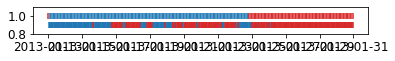

In [10]:
fig, ax = plt.subplots(figsize=(6, 0.5))
neg = flines.polarities > 0
ax.scatter(swics_data.index[neg], np.abs(flines.polarities[neg]), marker='|', color='C0')
ax.scatter(swics_data.index[~neg], np.abs(flines.polarities[~neg]), marker='|', color='C3')

neg = pol_l1 > 0
ax.scatter(mag_data.index[neg], np.abs(pol_l1[neg]) * 0.9, marker='|', color='C0')
ax.scatter(mag_data.index[~neg], np.abs(pol_l1[~neg]) * 0.9, marker='|', color='C3')

ax.set_ylim(0.8, 1.1)

Function to add shading for different source regions
---

In [11]:
def add_bands(axs):
    for ax in axs:
        for (stime, etime) in cme_times:
            ax.axvspan(stime, etime, color='k', alpha=0.2, zorder=20)
        for (stime, etime) in ar_outflow_times:
            ax.axvspan(stime, etime, color='C2', alpha=0.1)
        for (stime, etime) in ch_times:
            ax.axvspan(stime, etime, color='C4', alpha=0.1)

Various plot formatting helpers
---

In [12]:
def long_formatter():
    def wrap(x, val):
        if x < 0:
            x = x + 360
        return f'{x}$^{{\circ}}$'
    return mticker.FuncFormatter(wrap)

def set_degree_yaxis(ax):
    ax.yaxis.set_major_locator(mticker.FixedLocator([-180, -90, 0, 90, 180]))
    ax.yaxis.set_major_formatter(mticker.StrMethodFormatter('{x}$^{{\circ}}$'))
    ax.set_ylim(-180, 180)
    
def add_source_labels(ax):
    yval = 580
    for (cme_time, _) in cme_times:
        ax.text(cme_time + timedelta(hours=0), yval, 'CME')
    for (time, _) in ar_outflow_times:
        ax.text(time + timedelta(hours=2), yval, 'AR', color='tab:green')
    for i, (time, _) in enumerate(ch_times):
        ax.text(time + timedelta(hours=2), yval, f'CH{i + 1}', color='tab:purple')

Big in-situ timeseries plot
---

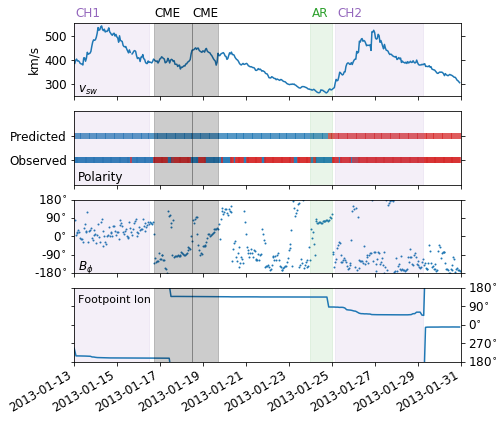

In [13]:
fig, axs = plt.subplots(nrows=4, sharex=True, figsize=(figwidth, figwidth))

# Solar wind speed
ax = axs[0]
ax.plot(proton_data.index, vp_r)
# Formatting
ax.set_ylabel('km/s')
ax.text(0.01, 0.05, '$v_{sw}$', transform=ax.transAxes)

# Polarities
ax = axs[1]
neg = flines.polarities > 0
ax.scatter(swics_data.index[neg], np.abs(flines.polarities[neg]), marker='|', color='C0')
ax.scatter(swics_data.index[~neg], np.abs(flines.polarities[~neg]), marker='|', color='C3')

neg = pol_l1 > 0
ax.scatter(mag_data.index[neg], np.abs(pol_l1[neg]) * 0.9, marker='|', color='C0')
ax.scatter(mag_data.index[~neg], np.abs(pol_l1[~neg]) * 0.9, marker='|', color='C3')
ax.set_ylim(0.8, 1.1)
ax.set_yticks([0.9, 1])
ax.set_yticklabels(['Observed', 'Predicted'])
ax.text(0.01, 0.05, 'Polarity', transform=ax.transAxes)

# Bphi
ax = axs[2]
# Plot data
ax.scatter(mag_data.index, Bphi_actual, s=1)
# Formatting
ax.text(0.01, 0.05, '$B_{\phi}$', transform=ax.transAxes)
set_degree_yaxis(ax)

# Solar fooptoint
isopen = flines.polarities != 0
feet = flines.open_field_lines.solar_feet
feet.representation_type = 'spherical'

# Longitude
ax = axs[3]
ax.plot(swics_data.index[isopen], feet.lon)
ax.plot(swics_data.index[isopen], feet.lon - 360 * u.deg, color='C0')
ax.text(0.01, 0.8, 'Footpoint lon', color='black', transform=ax.transAxes, size=11)
ax.yaxis.tick_right()
ax.set_ylim(-180, 180)
ax.yaxis.set_major_locator(mticker.FixedLocator([-180, -90, 0, 90, 180]))
ax.yaxis.set_major_formatter(long_formatter())

# Whole axis formatting
add_bands(axs)
[ax.tick_params(which='both', left=True, right=True) for ax in axs]
# Add source region labels
add_source_labels(axs[0])
ax = axs[-1]
ax.set_xlim(starttime, endtime)

fig.autofmt_xdate()

In [14]:
fig.savefig('ace_overview.pdf', bbox_inches='tight')

Calculate EIS trace
---

In [15]:
import sunpy.coordinates.frames as sunframes

def map_interp_carrington(m, fpoints):
    """
    Given a SunPy map, and a series of footpoints, interpolate
    the map data on to the footpoints.
    """
    fpoints.representation_type='spherical'
    fpoints = sunframes.HeliographicCarrington(fpoints.lon, fpoints.lat, fpoints.radius, obstime=m.date)
    pixels = m.world_to_pixel(fpoints)
    x, y = (pixels.x / u.pix).astype(int), (pixels.y / u.pix).astype(int)
    trace = m.data[y, x]
    # Remove points that are behind the Sun
    # trace = trace.astype(float)
    # trace[fpoints.distance > m.dsun] = np.nan
    return trace

In [16]:
eis_map = sunpy.map.Map('maps/carrington_fip_bias.fits')
feet = flines.open_field_lines.solar_feet
feet.representation_type = 'spherical'
fip_trace = map_interp_carrington(eis_map, flines.open_field_lines.solar_feet)

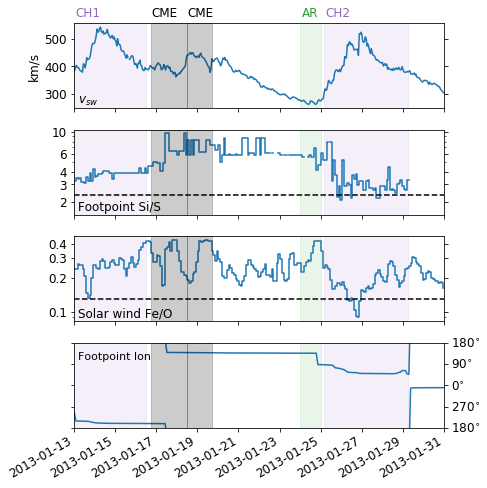

In [17]:
fig, axs = plt.subplots(nrows=4, sharex=True)

ax = axs[0]
ax.plot(proton_data.index, vp_r, label='$v_{pr}$')
ax.set_ylabel('km/s')
ax.text(0.01, 0.05, '$v_{sw}$', transform=ax.transAxes)

ax = axs[2]
ax.step(swics_data.index, swics_data.quantity('FetoO'), where='post')
ax.set_yscale('log')
ax.yaxis.set_major_formatter(mticker.StrMethodFormatter('{x:.1f}'))
ax.yaxis.set_major_locator(mticker.FixedLocator([0.1, 0.2, 0.3, 0.4]))
ax.text(0.01, 0.05, 'Solar wind Fe/O', transform=ax.transAxes)
ax.axhline(0.13, color='black', linestyle='--')

ax = axs[1]
ax.step(swics_data.index[isopen], fip_trace * 2.34)
ax.set_yscale('log')
ax.yaxis.set_major_formatter(mticker.StrMethodFormatter('{x:.0f}'))
ax.yaxis.set_major_locator(mticker.FixedLocator([2, 3, 4, 6, 10]))
ax.text(0.01, 0.05, 'Footpoint Si/S', transform=ax.transAxes)
ax.set_ylim(bottom=1.5)
ax.axhline(2.34, color='black', linestyle='--')

ax = axs[3]
# Longitude
ax = axs[3]
ax.plot(swics_data.index[isopen], feet.lon)
ax.plot(swics_data.index[isopen], feet.lon - 360 * u.deg, color='C0')
ax.text(0.01, 0.8, 'Footpoint lon', color='black', transform=ax.transAxes, size=11)
ax.yaxis.tick_right()
ax.set_ylim(-180, 180)
ax.yaxis.set_major_locator(mticker.FixedLocator([-180, -90, 0, 90, 180]))
ax.yaxis.set_major_formatter(long_formatter())

add_bands(axs)
add_source_labels(axs[0])
[ax.tick_params(which='both', left=True, right=True) for ax in axs]

ax = axs[-1]
ax.set_xlim(starttime, endtime)
fig.autofmt_xdate()
fig.tight_layout()

In [18]:
fig.savefig('ace_eis_comparison.pdf', bbox_inches='tight')

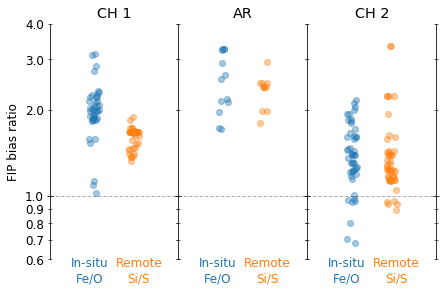

In [19]:
fig, axs = plt.subplots(ncols=3, sharey=True, sharex=True, figsize=(figwidth, 5 / 8 * figwidth))

for i, (sdate, edate) in enumerate(ch_times[0:1] + ar_outflow_times + ch_times[1:2]):
    ax = axs[i]
    
    feo = swics_data.data['FetoO'][isopen]
    keep = (feo.index > sdate) & (feo.index < edate)
    feo = feo[keep]
    fip = fip_trace[keep]
    fip = fip[np.isfinite(fip)]
    ax.scatter(np.random.rand(*feo.shape) - 2, feo * 7.64, alpha=0.4)
    ax.scatter(np.random.rand(*fip.shape) + 2, fip, alpha=0.4)
    
    ax.set_xlim(-6, 7)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.xaxis.set_visible(False)
    ax.text(-2, 0.5, 'In-situ\nFe/O', color='tab:blue',
            fontsize=12, horizontalalignment='center')
    ax.text(3, 0.5, 'Remote\nSi/S', color='tab:orange',
                fontsize=12, horizontalalignment='center')
    ax.tick_params(which='both', direction='inout', left=True, right=True)
    ax.tick_params(which='major', length=6)
    ax.tick_params(which='minor', length=4)
    ax.axhline(1, color='black', linestyle='--', linewidth=1, alpha=0.3)


axs[0].set_yscale('log')
axs[0].set_title('CH 1')
axs[1].set_title('AR')
axs[2].set_title('CH 2')

axs[0].set_ylabel('FIP bias ratio')
axs[0].yaxis.set_major_formatter(mticker.StrMethodFormatter('{x:.1f}'))
axs[0].yaxis.set_minor_formatter(mticker.StrMethodFormatter('{x:.1f}'))
axs[0].set_ylim(0.6, 4)

fig.subplots_adjust(wspace=0)

In [20]:
fig.savefig('boxplot_feo.pdf', bbox_inches='tight')